# Modelling Results - Reference Predictions

In this notebook, the predictions from the reference model are utilized. For detailed theoretical information, please refer to the report.


After training a Graph Neural Network (GNN), additional features were evaluated using a Random Forest (RF) model. Key features included GNN prediction scores, cosine similarity, and various node metrics like in-degree, out-degree, and cluster coefficients. Permutation Importance was applied to identify the most influential features. 

Permutation importance is a model-agnostic technique to evaluate feature importance by assessing the change in a model's performance after shuffling the values of a specific feature. A significant drop in performance suggests the feature is crucial for accurate predictions. This process is iterated to obtain a stable importance score.


To ensure robustness, a 5-fold cross-validation was performed on the validation set, followed by testing on the test set to verify generalization. This approach ensures that the model's performance and the selected features are reliable and effective.

In [ ]:
import os
current_dir = os.getcwd()
if os.path.basename(current_dir) != 'link-prediction-in-graphs':
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
print(f"current working directory: {os.getcwd()}")

import torch
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from ogb.nodeproppred import NodePropPredDataset
import seaborn as sns
import dask.dataframe as dd
from dask.multiprocessing import get
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from ogb.linkproppred import Evaluator
from joblib import dump,load
# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18 
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18
dataset = "ogbn-arxiv"

data_path = "./dataset/sample_data_for_evaluation_build/gcn_reference/valid/"
data = NodePropPredDataset(name=dataset)
from modelling.dataset_split.dataset_splitter import Dataset_Splitter

In [37]:
ds_split = Dataset_Splitter()
dataset_ = ds_split.load_dataset(dataset)
split_edge, edge_index = ds_split.get_edges_split(dataset_)

Creating Splits for dataset ogbn-arxiv
Returning Splits for dataset ogbn-arxiv


In [38]:
source = np.load(f"{data_path}source.npy")
source_multiplied = np.array(torch.tensor(source).view(-1, 1).repeat(1, 1000).view(-1))
target_neg = np.load(f"{data_path}target_neg.npy")
target_pos = np.load(f"{data_path}target.npy")
neg_preds = np.load(f"{data_path}neg_preds.npy")
pos_preds = np.load(f"{data_path}pos_preds.npy")

In [39]:
train_edges = torch.load(f"./temp/split_edge-{dataset}.pt")["train"]
train_edges = np.array([train_edges["source_node"],train_edges["target_node"]])

In [40]:
nodes = set(np.hstack((np.unique(train_edges),source,np.unique(target_neg),target_pos)))
unique_validation_nodes = set(np.hstack((source,np.unique(target_neg),target_pos)))

nx_graph = nx.DiGraph()
nx_graph.add_nodes_from(nodes)
nx_graph.add_edges_from(train_edges.T)

## Build Node Feature Dataframe

Here the node feature dataframe is build. This are all the features, which can be calculated for each node.

In [31]:
clustering_source = nx.clustering(nx_graph,unique_validation_nodes)

In [32]:
nodes_in_strong_connected_components = set.union(*(set(s) for s in nx.strongly_connected_components(nx_graph) if len(s)!=1))
nodes_in_strong = {node: node in nodes_in_strong_connected_components for node in unique_validation_nodes}

In [33]:
in_degrees = dict(nx_graph.in_degree())
in_degrees_source_nodes = {key:in_degrees.get(key) for key in unique_validation_nodes}
out_degrees = dict(nx_graph.out_degree())
out_degrees_source_nodes = {key:out_degrees.get(key) for key in unique_validation_nodes}

In [34]:
years_nodes = data[0][0]["node_year"]
year_of_nodes = {i:years_nodes[i][0] for i in range(len(years_nodes))}

In [35]:
df1 = pd.DataFrame([clustering_source]).T.rename(columns={0:"clustering_coeffficient"})
df2 = pd.DataFrame([in_degrees_source_nodes]).T.rename(columns={0:"in_degrees"})
df3 = pd.DataFrame([out_degrees_source_nodes]).T.rename(columns={0:"out_degrees"})
df4 = pd.DataFrame([nodes_in_strong]).T.rename(columns={0:"node_in_strong"})
df5 = pd.DataFrame([year_of_nodes]).T.rename(columns={0:"node_year"})
df6 = pd.read_csv("./dataset/ogbn_arxiv/raw/node-label.csv.gz",header=None).rename(columns={0:"node_label"})

# Concatenate transposed DataFrames along columns
feature_df = pd.concat([df1, df2, df3,df4,df5,df6], axis=1).reset_index(names="Node Index")
feature_df

,Node Index,clustering_coeffficient,in_degrees,out_degrees,node_in_strong,node_year,node_label
0,0,0.015654,283,2,False,2013,4
1,1,0.000000,0,1,False,2015,5
2,2,0.142857,5,2,True,2014,28
3,3,0.000000,1,0,False,2014,8
4,4,0.400000,5,1,False,2014,27
...,...,...,...,...,...,...,...
169338,169338,0.121505,0,31,False,2020,4
169339,169339,0.166667,1,2,False,2020,24
169340,169340,0.140523,1,17,False,2020,10
169341,169341,0.134211,3,17,False,2020,4


In [ ]:
#feature_df.to_csv("./dataset/modelling_results_calc_saved/feature_per_node_test.csv")
feature_df.to_csv("./dataset/modelling_results_calc_saved/feature_per_node.csv") 

## Build Prediction Dataframe

Here the link feature dataframe is build. This are all the features, which can be calculated for each link.

In [37]:
def calc_common_neighbours(nx_graph,u,v):
    common = len(set(nx_graph.successors(u)) & set(nx_graph.successors(v)))
    return common

def calc_common_neighbours_preds_and_succ(nx_graph,u,v):
    common = len(set.union(set(nx_graph.predecessors(u)), set(nx_graph.successors(u))) & set.union(set(nx_graph.predecessors(v)), set(nx_graph.successors(v))))
    return common

In [38]:
pred_pos_df = pd.DataFrame((source,target_pos)).T.rename(columns={0:"source",1:"target"})
pred_pos_df['common_neighbours_succ'] = pred_pos_df.apply(lambda row: calc_common_neighbours(nx_graph, row['source'], row['target']), axis=1)
pred_pos_df['common_neighbours_all'] = pred_pos_df.apply(lambda row: calc_common_neighbours_preds_and_succ(nx_graph, row['source'], row['target']), axis=1)

In [39]:
def calc_cosine(source, target, node_features):
    return cosine_similarity(node_features[source].reshape(1, -1), node_features[target].reshape(1, -1))[0][0]


node_features = data[0][0]["node_feat"]
pred_pos_df['cosine_similarity'] = pred_pos_df.apply(lambda row: calc_cosine(row['source'], row['target'], node_features), axis=1)

In [40]:
pred_pos_df_featured = pd.merge(pred_pos_df,feature_df,left_on="source",right_on="Node Index").rename(
    columns={"clustering_coeffficient":"clustering_coeffficient_source","in_degrees":"in_degrees_source","out_degrees":"out_degrees_source","node_in_strong":"node_in_strong_source","node_label": "arxiv_category_source"}).drop(columns=["Node Index","node_year"])
pred_pos_df_featured = pd.merge(pred_pos_df_featured,feature_df,left_on="target",right_on="Node Index").rename(
    columns={"clustering_coeffficient":"clustering_coeffficient_target","in_degrees":"in_degrees_target","out_degrees":"out_degrees_target","node_in_strong":"node_in_strong_target","node_year":"node_year_target","node_label":"arxiv_category_target"}).drop(columns="Node Index")
pred_pos_df_featured["output"] = True

In [41]:
pred_neg_df = pd.DataFrame({'source': source_multiplied, 'target': target_neg})
pred_neg_df['common_neighbours_succ'] = pred_neg_df.apply(lambda row: calc_common_neighbours(nx_graph, row['source'], row['target']), axis=1)
pred_neg_df['common_neighbours_all'] = pred_neg_df.apply(lambda row: calc_common_neighbours_preds_and_succ(nx_graph, row['source'], row['target']), axis=1)

In [42]:
# calc cosine similarity
ddf = dd.from_pandas(pred_neg_df, npartitions=64)
def calc_cosine_row(row):
    return calc_cosine(row['source'], row['target'], node_features)
ddf['cosine_similarity'] = ddf.apply(calc_cosine_row, axis=1, meta=('float'))
pred_neg_df = ddf.compute(scheduler=get)

/opt/conda/lib/python3.11/site-packages/dask/dataframe/core.py:7364: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [43]:
pred_neg_df_featured = pd.merge(pred_neg_df,feature_df,left_on="source",right_on="Node Index").rename(
    columns={"clustering_coeffficient":"clustering_coeffficient_source","in_degrees":"in_degrees_source","out_degrees":"out_degrees_source","node_in_strong":"node_in_strong_source","node_label": "arxiv_category_source"}).drop(columns=["Node Index","node_year"])
pred_neg_df_featured = pd.merge(pred_neg_df_featured,feature_df,left_on="target",right_on="Node Index").rename(
    columns={"clustering_coeffficient":"clustering_coeffficient_target","in_degrees":"in_degrees_target","out_degrees":"out_degrees_target","node_in_strong":"node_in_strong_target","node_year":"node_year_target","node_label":"arxiv_category_target"}).drop(columns="Node Index")
pred_neg_df_featured["output"] = False

In [ ]:
#pred_pos_df_featured.to_csv("./dataset/modelling_results_calc_saved/pred_pos_df_featured_test.csv")
#pred_neg_df_featured.to_csv("./dataset/modelling_results_calc_saved/pred_neg_df_featured_test.csv")
pred_pos_df_featured.to_csv("./dataset/modelling_results_calc_saved/pred_pos_df_featured.csv")
pred_neg_df_featured.to_csv("./dataset/modelling_results_calc_saved/pred_neg_df_featured.csv")

## load precalculated_data

If the dataset is already calculated it can be loaded here.

In [41]:
pred_pos_df_featured = pd.read_csv("./dataset/modelling_results_calc_saved/pred_pos_df_featured.csv", index_col=0)
pred_neg_df_featured = pd.read_csv("./dataset/modelling_results_calc_saved/pred_neg_df_featured.csv", index_col=0)

In [42]:
pos_preds = np.load(f"{data_path}pos_preds.npy")
neg_preds = np.load(f"{data_path}neg_preds.npy")
pred_pos_df_featured["prediction_model"] = pos_preds
pred_neg_df_featured["prediction_model"] = neg_preds.reshape(-1)


In [43]:
comined_pred_df_featured = pd.concat([pred_neg_df_featured,pred_pos_df_featured])

## GCN Reference

### Overall Importances

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_to_select = "Random Forest"
features_to_drop = ["source","target"]
mrr_list = []
n=0
for train_index, test_index in kf.split(source):
    n+=1
    X_train = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[train_index])].copy()
    y_train = X_train.pop("output").values
    X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
    y_test = X_test.pop("output").values
    if model_to_select == "Random Forest":
        model = RandomForestClassifier(n_estimators=120, random_state=42,n_jobs = -1)
    elif model_to_select == "Logistic Regression":
        model = LogisticRegression()
    model.fit(X_train.copy().drop(columns=features_to_drop), y_train)

    X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

    X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

    evaluator = Evaluator(name='ogbl-citation2')
    eval_dict = evaluator.eval({
                'y_pred_pos': torch.tensor(y_pred_pos),
                'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
            })
    print(eval_dict["mrr_list"].mean())
    mrr_list.append(eval_dict["mrr_list"].mean())
    dump(model, f'./models_saved/random_forest_model_{n}.joblib')

tensor(0.9250)


In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_to_select = "Random Forest"
features_to_drop = ["source","target"]
mrr_list = []
n=0
for train_index, test_index in kf.split(source):
    n+=1

    X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
    y_test = X_test.pop("output").values
    if model_to_select == "Random Forest":
        model = load(f'./models_saved/random_forest_model_{n}.joblib')
    elif model_to_select == "Logistic Regression":
        model = LogisticRegression()
        
    X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

    X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

    evaluator = Evaluator(name='ogbl-citation2')
    eval_dict = evaluator.eval({
                'y_pred_pos': torch.tensor(y_pred_pos),
                'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
            })
    print(eval_dict["mrr_list"].mean())
    mrr_list.append(eval_dict["mrr_list"].mean())

tensor(0.9252)
tensor(0.9300)
tensor(0.9293)
tensor(0.9271)
tensor(0.9250)


In [24]:
perm_importance = []
n_times = 2
for col in X_test_pos.columns:
    if col not in features_to_drop:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        saved_per_model = []
        model_n = 0
        for train_index, test_index in kf.split(source):
            model_n +=1
            model = load(f'./models_saved/random_forest_model_{model_n}.joblib')
            X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
            y_test = X_test.pop("output").values

            X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

            X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]
            
            saved_per_feature = []
            for x in range(n_times):
                X_test_neg_permuted = X_test_neg.copy()
                X_test_pos_permuted = X_test_pos.copy()

                permuted_columns = np.random.permutation(np.hstack((X_test_pos_permuted[col].values,X_test_neg_permuted[col].values)))
                X_test_neg_permuted[col] = permuted_columns[:X_test_neg_permuted.shape[0]]
                X_test_pos_permuted[col] = permuted_columns[X_test_neg_permuted.shape[0]:]

                y_pred_pos = model.predict_proba(X_test_pos_permuted.copy().drop(columns=features_to_drop))[:,1]
                y_pred_neg = model.predict_proba(X_test_neg_permuted.copy().drop(columns=features_to_drop))[:,1]
                evaluator = Evaluator(name='ogbl-citation2')
                eval_dict = evaluator.eval({
                            'y_pred_pos': torch.tensor(y_pred_pos),
                            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
                        })
                importance = mrr_list[model_n-1] -  eval_dict["mrr_list"].mean()
                saved_per_feature.append(importance)
            saved_per_model.append((np.mean(saved_per_feature)))
        perm_importance.append((col, np.mean(saved_per_model),np.std(saved_per_model)))
perm_importance.sort(key=lambda x: x[1], reverse=True)

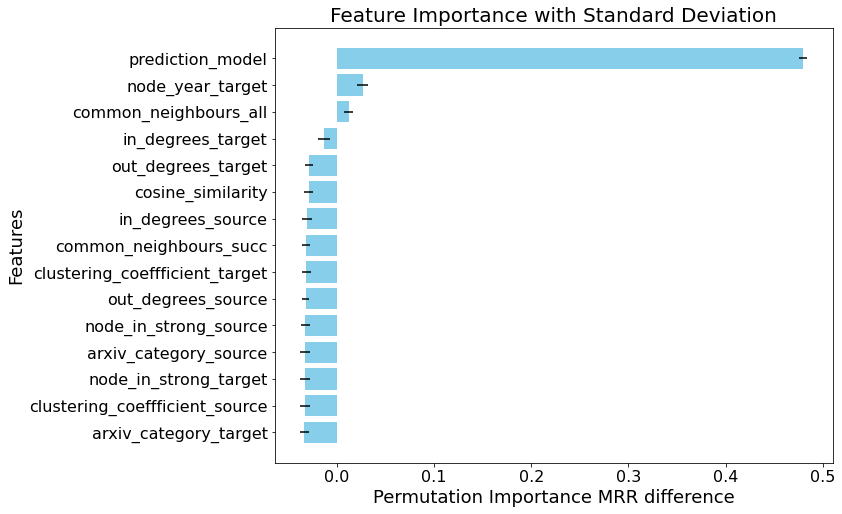

In [25]:
labels, values, errors = zip(*perm_importance)

# Creating the bar plot with error bars
plt.figure(figsize=(10, 8))
plt.barh(labels, values, xerr=errors, color='skyblue')
plt.xlabel('Permutation Importance MRR difference')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.savefig("gcn_reference_permutation_importnace_all_features.pdf", format='pdf',dpi=5000,bbox_inches='tight')
plt.show()

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_to_select = "Random Forest"
features_to_drop = comined_pred_df_featured.columns[~comined_pred_df_featured.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]
mrr_list = []
n=0
for train_index, test_index in kf.split(source):
    n+=1
   
    X_train = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[train_index])].copy()
    y_train = X_train.pop("output").values
    X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
    y_test = X_test.pop("output").values
    if model_to_select == "Random Forest":
        model = RandomForestClassifier(n_estimators=120, random_state=42,n_jobs = -1)
    elif model_to_select == "Logistic Regression":
        model = LogisticRegression()
    model.fit(X_train.copy().drop(columns=features_to_drop), y_train)
    
    X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

    X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
    y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

    evaluator = Evaluator(name='ogbl-citation2')
    eval_dict = evaluator.eval({
                'y_pred_pos': torch.tensor(y_pred_pos),
                'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
            })
    print(eval_dict["mrr_list"].mean())
    mrr_list.append(eval_dict["mrr_list"].mean())
    dump(model, f'./models_saved/random_forest_model_further_trained{n}.joblib')

tensor(0.8914)
tensor(0.8949)
tensor(0.8902)
tensor(0.8994)
tensor(0.8936)


In [27]:
mrr_list = [0.8914,0.8949,0.8902,0.8994,0.8936]
features_to_drop = comined_pred_df_featured.columns[~comined_pred_df_featured.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]

In [28]:
perm_importance = []
n_times = 2
for col in X_test_pos.columns:
    if col not in features_to_drop:
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        saved_per_model = []
        model_n = 0
        for train_index, test_index in kf.split(source):
            model_n +=1
            model = load(f'./models_saved/random_forest_model_further_trained{model_n}.joblib')
            
            X_test = comined_pred_df_featured[comined_pred_df_featured["source"].isin(source[test_index])].copy()
            y_test = X_test.pop("output").values

            X_test_pos = pred_pos_df_featured[pred_pos_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

            X_test_neg = pred_neg_df_featured[pred_neg_df_featured["source"].isin(source[test_index])].copy().drop(columns="output")
            y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]
            
            saved_per_feature = []
            for x in range(n_times):
                X_test_neg_permuted = X_test_neg.copy()
                X_test_pos_permuted = X_test_pos.copy()

                permuted_columns = np.random.permutation(np.hstack((X_test_pos_permuted[col].values,X_test_neg_permuted[col].values)))
                X_test_neg_permuted[col] = permuted_columns[:X_test_neg_permuted.shape[0]]
                X_test_pos_permuted[col] = permuted_columns[X_test_neg_permuted.shape[0]:]

                y_pred_pos = model.predict_proba(X_test_pos_permuted.copy().drop(columns=features_to_drop))[:,1]
                y_pred_neg = model.predict_proba(X_test_neg_permuted.copy().drop(columns=features_to_drop))[:,1]
                evaluator = Evaluator(name='ogbl-citation2')
                eval_dict = evaluator.eval({
                            'y_pred_pos': torch.tensor(y_pred_pos),
                            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
                        })
                mrr_mean = eval_dict["mrr_list"].mean()
                importance = mrr_list[model_n-1] - mrr_mean
                saved_per_feature.append(importance)
            saved_per_model.append((np.mean(saved_per_feature)))
        perm_importance.append((col, np.mean(saved_per_model),np.std(saved_per_model)))
perm_importance.sort(key=lambda x: x[1], reverse=True)

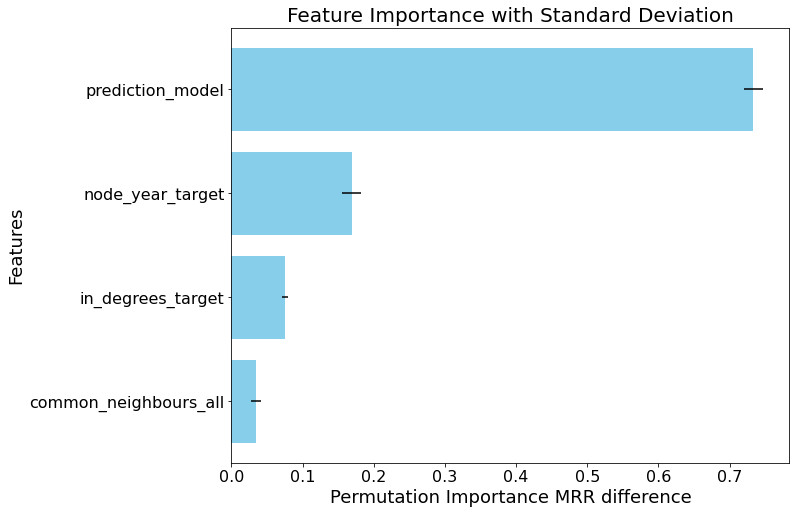

In [30]:
labels, values, errors = zip(*perm_importance)

# Creating the bar plot with error bars
plt.figure(figsize=(10, 8))
plt.barh(labels, values, xerr=errors, color='skyblue')
plt.xlabel('Permutation Importance MRR difference')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.savefig("gcn_reference_permutation_importnace_four_features.pdf", format='pdf',dpi=5000,bbox_inches='tight')
plt.show()

### Test on testset

Here the random forest model is trained on the validation set and tested on the testset.

In [31]:
data_path_test = "./dataset/sample_data_for_evaluation_build/gcn_reference/test/"
pos_preds_test = np.load(f"{data_path_test}pos_preds.npy")
neg_preds_test = np.load(f"{data_path_test}neg_preds.npy")
pred_pos_df_featured_test= pd.read_csv("./dataset/modelling_results_calc_saved/pred_pos_df_featured_test.csv", index_col=0)
pred_neg_df_featured_test = pd.read_csv("./dataset/modelling_results_calc_saved/pred_neg_df_featured_test.csv", index_col=0)
pred_pos_df_featured_test["prediction_model"] = pos_preds_test
pred_neg_df_featured_test["prediction_model"] = neg_preds_test.reshape(-1)
comined_pred_df_featured_test = pd.concat([pred_neg_df_featured_test,pred_pos_df_featured_test])

features_to_drop = comined_pred_df_featured_test.columns[~comined_pred_df_featured_test.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]


In [ ]:
model_to_select = "Random Forest"
features_to_drop = comined_pred_df_featured.columns[~comined_pred_df_featured.columns.isin(["output","prediction_model","node_year_target","common_neighbours_all","in_degrees_target"])]
   
X_train = comined_pred_df_featured.copy()
y_train = X_train.pop("output").values
X_test = comined_pred_df_featured_test.copy()
y_test = X_test.pop("output").values
if model_to_select == "Random Forest":
    model = RandomForestClassifier(n_estimators=120, random_state=42,n_jobs = -1)
elif model_to_select == "Logistic Regression":
    model = LogisticRegression()
model.fit(X_train.copy().drop(columns=features_to_drop), y_train)

X_test_pos = pred_pos_df_featured_test.copy().drop(columns="output")
y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

X_test_neg = pred_neg_df_featured_test.copy().drop(columns="output")
y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

evaluator = Evaluator(name='ogbl-citation2')
eval_dict = evaluator.eval({
            'y_pred_pos': torch.tensor(y_pred_pos),
            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
        })
print(eval_dict["mrr_list"])
dump(model, f'./models_saved/random_forest_model_further_trained_full_data.joblib')

In [32]:
model = load(f'./models_saved/random_forest_model_further_trained_full_data.joblib')

X_test_pos = pred_pos_df_featured_test.copy().drop(columns="output")
y_pred_pos = model.predict_proba(X_test_pos.copy().drop(columns=features_to_drop))[:,1]

X_test_neg = pred_neg_df_featured_test.copy().drop(columns="output")
y_pred_neg = model.predict_proba(X_test_neg.copy().drop(columns=features_to_drop))[:,1]

evaluator = Evaluator(name='ogbl-citation2')
eval_dict = evaluator.eval({
            'y_pred_pos': torch.tensor(y_pred_pos),
            'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
        })

In [33]:
perm_importance = []
result = eval_dict["mrr_list"].mean()
n_times = 5
model = load(f'./models_saved/random_forest_model_further_trained_full_data.joblib')
for col in X_test_pos.columns:
    if col not in features_to_drop:            

        saved_per_feature = []
        for x in range(n_times):
            X_test_neg_permuted = X_test_neg.copy()
            X_test_pos_permuted = X_test_pos.copy()

            permuted_columns = np.random.permutation(np.hstack((X_test_pos_permuted[col].values,X_test_neg_permuted[col].values)))
            X_test_neg_permuted[col] = permuted_columns[:X_test_neg_permuted.shape[0]]
            X_test_pos_permuted[col] = permuted_columns[X_test_neg_permuted.shape[0]:]

            y_pred_pos = model.predict_proba(X_test_pos_permuted.copy().drop(columns=features_to_drop))[:,1]
            y_pred_neg = model.predict_proba(X_test_neg_permuted.copy().drop(columns=features_to_drop))[:,1]
            evaluator = Evaluator(name='ogbl-citation2')
            eval_dict = evaluator.eval({
                        'y_pred_pos': torch.tensor(y_pred_pos),
                        'y_pred_neg': torch.tensor(y_pred_neg).view(-1,1000),
                    })
            mrr_mean = eval_dict["mrr_list"].mean()
            importance = result - mrr_mean
            saved_per_feature.append(importance)
        perm_importance.append((col, np.mean(saved_per_feature),np.std(saved_per_feature)))
perm_importance.sort(key=lambda x: x[1], reverse=True)

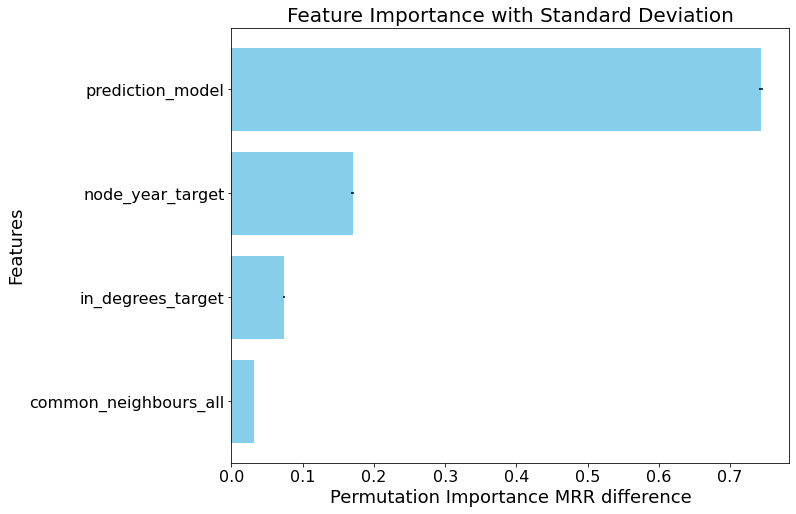

In [35]:
labels, values, errors = zip(*perm_importance)

# Creating the bar plot with error bars
plt.figure(figsize=(10, 8))
plt.barh(labels, values, xerr=errors, color='skyblue')
plt.xlabel('Permutation Importance MRR difference')
plt.ylabel('Features')
plt.title('Feature Importance with Standard Deviation')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.savefig("gcn_reference_permutation_importnace_four_features_test.pdf", format='pdf',dpi=5000,bbox_inches='tight')
plt.show()

## Calculate Correlation Matrix

Correlation matrices to check for correlation between the features. In the first plot the correlation between node specific features are tested. In the second plot the link specific features are added aswell.

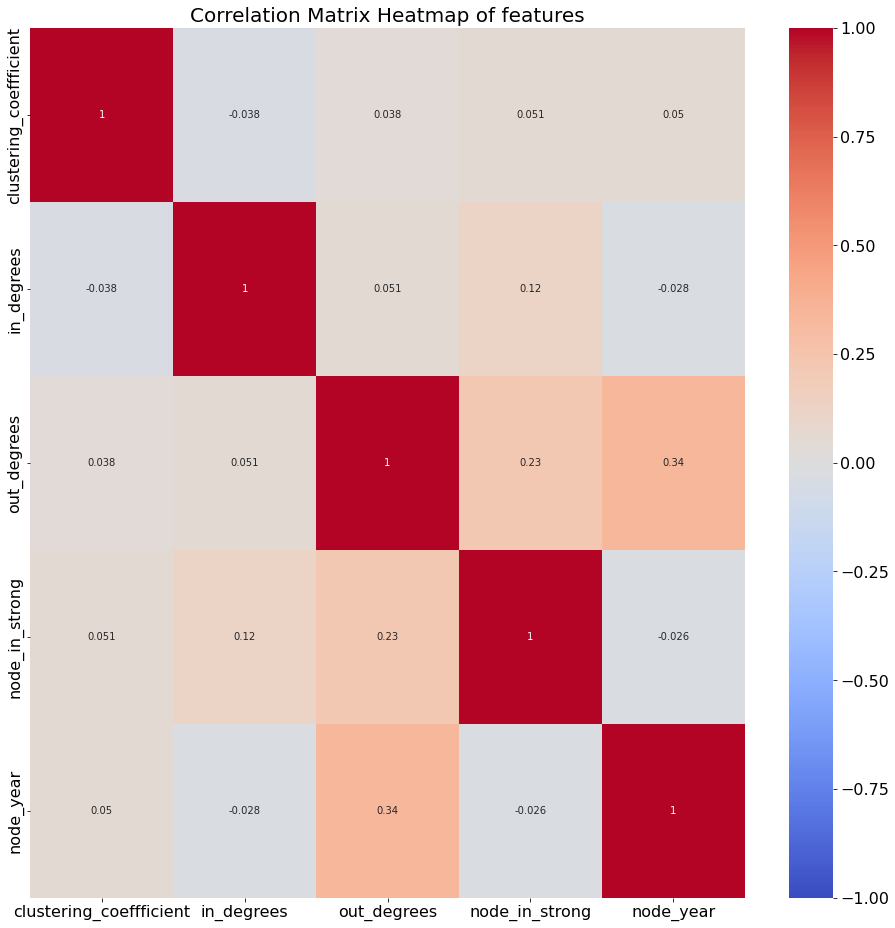

In [ ]:
correlation_matrix =feature_df.drop(columns = ["Node Index","node_label"]).corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap of features')
plt.savefig("feature_df.pdf", format='pdf',dpi=2000,bbox_inches='tight')

plt.show()

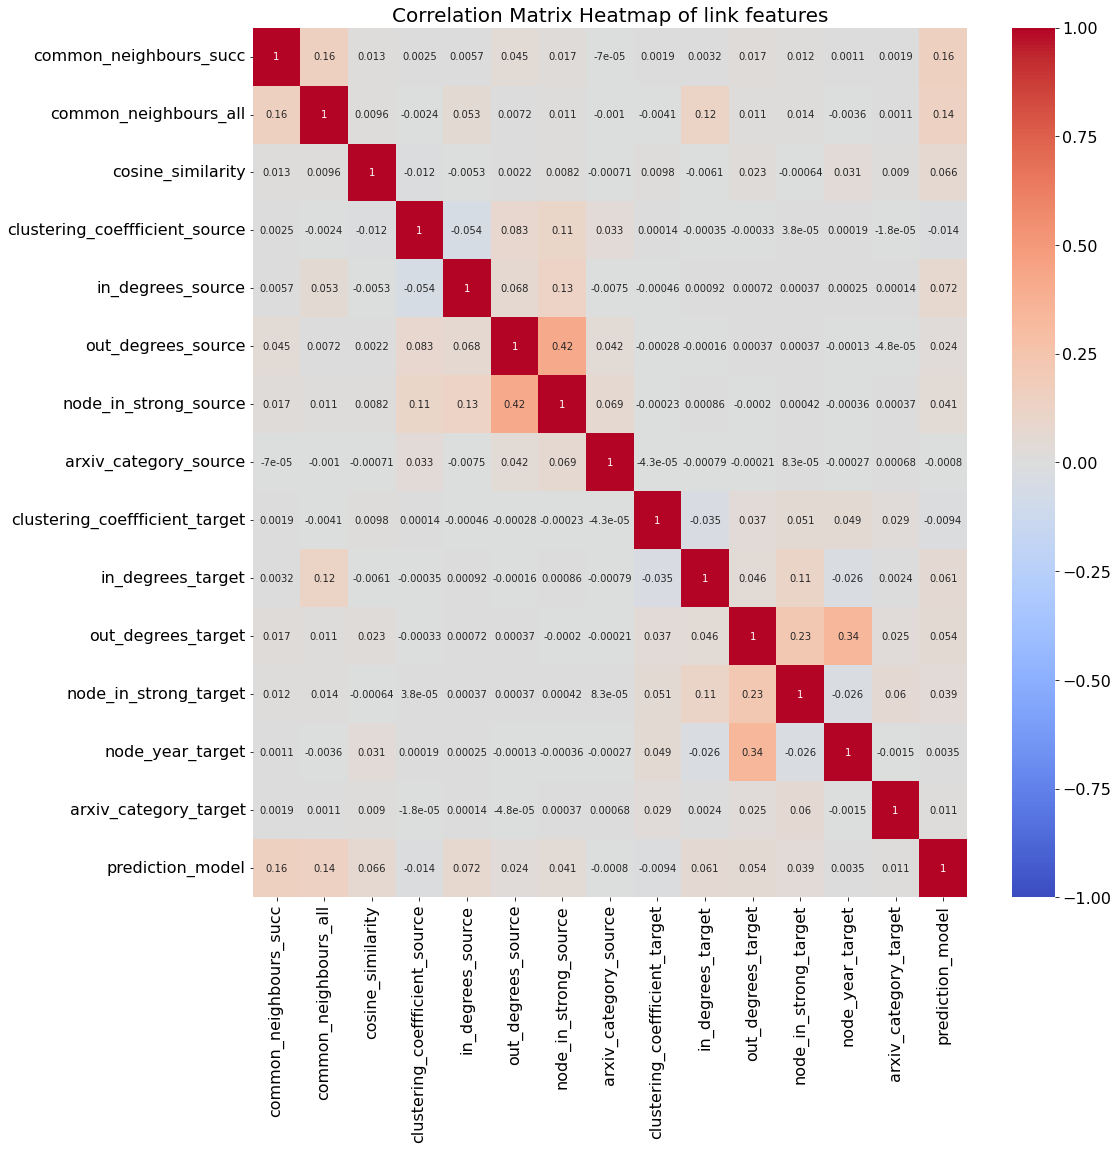

In [ ]:
correlation_matrix =comined_pred_df_featured.drop(columns = ["source","target","output"]).corr()
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap of link features')
plt.savefig("gcn_transfer_Correlation Matrix Heatmap.pdf", format='pdf',dpi=2000,bbox_inches='tight')

plt.show()